### Reconstrução de H(z) via Processo Gaussiano (GP)

 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/lazarolima/.local/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


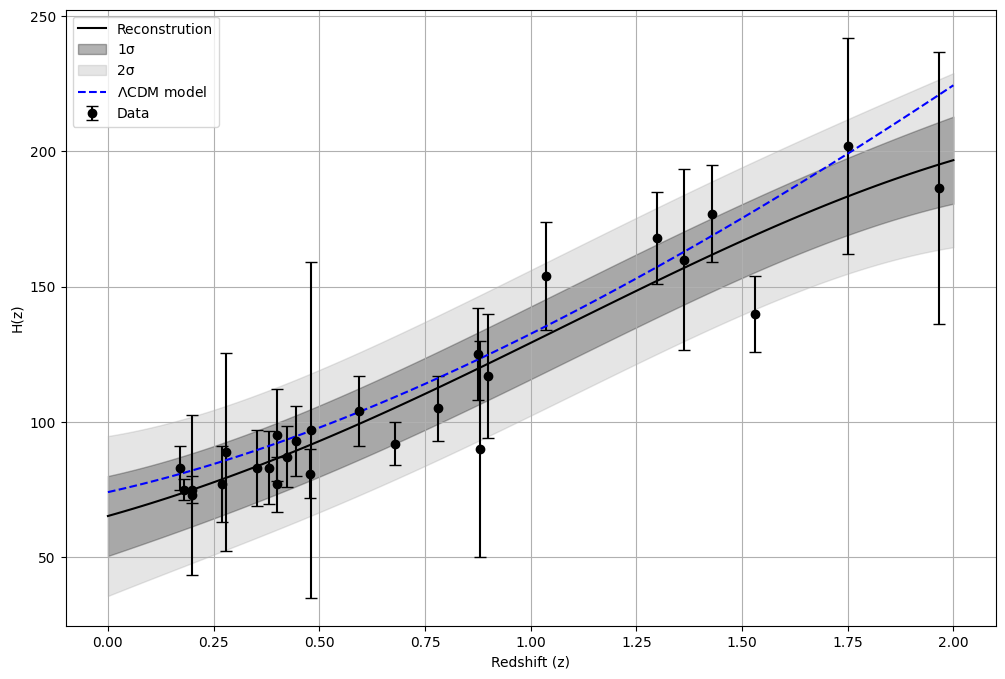

In [1]:
import equations as eq
import matplotlib.pyplot as plt
import numpy as np
import gaussian_process as gp
import obs_data as od

z_values = od.z_func()
H_obs = od.H_func()
errors = od.errors_func()

# Obter valores de predição
mean, var, mean_deriv, var_deriv = gp.pred()

# Modelo LambdaCDM plano
z_test = gp.z_pred()
H_theory = eq.H_padrao(z_test.flatten())

# Plotar os resultados
plt.figure(figsize=(12, 8))

# Dados originais com barras de erro
plt.errorbar(z_values, H_obs, yerr=errors, fmt='o', capsize=4, color='k', label='Data')

# Função predita pelo GP
plt.plot(z_test, mean, 'k-', label='Reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ
plt.fill_between(z_test.flatten(), 
                 mean.flatten() - 1*np.sqrt(var.flatten()), 
                 mean.flatten() + 1*np.sqrt(var.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(z_test.flatten(), 
                 mean.flatten() - 2*np.sqrt(var.flatten()), 
                 mean.flatten() + 2*np.sqrt(var.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

plt.plot(z_test, H_theory, 'b--', label='$\\Lambda$CDM model')

plt.xlabel('Redshift (z)')
plt.ylabel('H(z)')
plt.legend()
plt.grid(True)


#### Gerando dados de Mock de FRBs

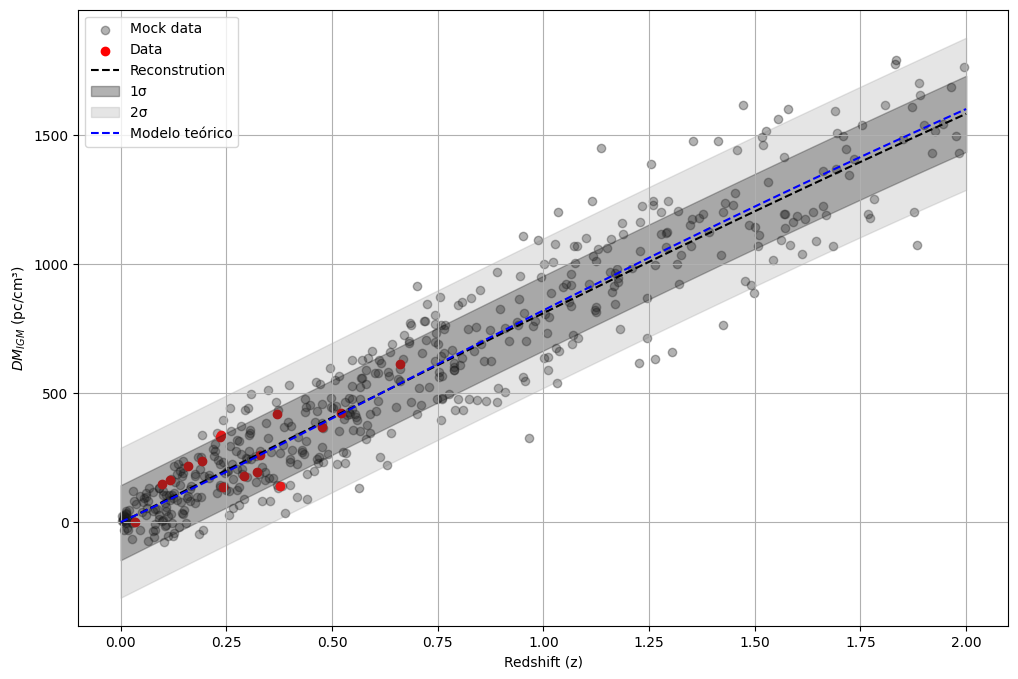

In [8]:
from mock import RedshiftSimulation

# Parâmetros para gerar novos dados
n_new = 500  # Número de novos pontos de dados
z_max = 2  # Máximo redshift

# Criar uma instância da classe RedshiftSimulation
sim = RedshiftSimulation(n_new, z_max)

# Gerar novos dados
sim.generate_redshifts()
sim.simulate_DM_IGM()

# Obter os resultados
new_z = sim.get_new_z()
DM_IGM_sim = sim.get_DM_IGM_sim()

# Agora você pode usar new_z e DM_IGM_sim como antes

# Obter valores de predição
mean1, var1, mean_deriv1, var_deriv1 = gp.pred_new()

# Plotar os resultados
plt.figure(figsize=(12, 8))

# Dados originais com barras de erro
plt.scatter(new_z, DM_IGM_sim, alpha=0.3, color='k', label='Mock data')
plt.scatter(od.z_obs, od.DM_IGM_obs, color='r', label='Data')

# Função predita pelo GP
plt.plot(gp.z_pred(), mean1, 'k--', label='Reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ
plt.fill_between(gp.z_pred().flatten(), 
                 mean1.flatten() - 1*np.sqrt(var1.flatten()), 
                 mean1.flatten() + 1*np.sqrt(var1.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(gp.z_pred().flatten(), 
                 mean1.flatten() - 2*np.sqrt(var1.flatten()), 
                 mean1.flatten() + 2*np.sqrt(var1.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

# Modelo teórico
dm_igm_theory = eq.DM_IGM(gp.z_pred().flatten())
plt.plot(gp.z_pred(), dm_igm_theory, 'b--', label='Modelo teórico')

plt.xlabel('Redshift (z)')
plt.ylabel('$DM_{IGM}$ (pc/cm³)')
plt.legend()
plt.grid(True)

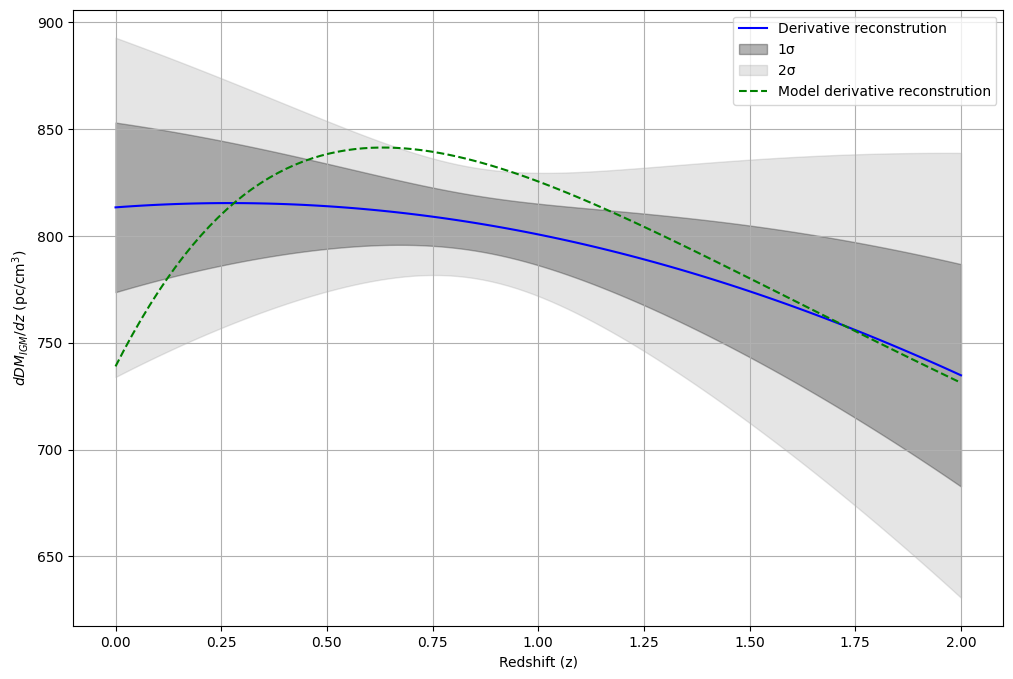

In [6]:
# Plotar as derivadas
plt.figure(figsize=(12, 8))
plt.plot(gp.z_pred(), mean_deriv1.flatten(), 'b-', label='Derivative reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ para a derivada
plt.fill_between(gp.z_pred().flatten(), 
                 mean_deriv1.flatten() - 1*np.sqrt(var_deriv1.flatten()), 
                 mean_deriv1.flatten() + 1*np.sqrt(var_deriv1.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(gp.z_pred().flatten(), 
                 mean_deriv1.flatten() - 2*np.sqrt(var_deriv1.flatten()), 
                 mean_deriv1.flatten() + 2*np.sqrt(var_deriv1.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

# Derivada de DM_IGM
dm_igm_deriv = eq.I(gp.z_pred().flatten())
plt.plot(gp.z_pred().flatten(), dm_igm_deriv, 'g--', label='Model derivative reconstrution')

plt.xlabel('Redshift (z)')
plt.ylabel('$dDM_{IGM}/dz$ (pc/cm$^{3}$)')
plt.legend()
plt.grid(True)

In [ ]:
# Parametrizações de F_IGM

def f_IGM_p2(z, f_IGM, alpha):
    return f_IGM + alpha * z / (1 + z)

def f_IGM_p3(z, f_IGM, alpha):
    return f_IGM + alpha * z * np.exp(-z)

# Parâmetro de Hubble

def H_p1(z, f_IGM):
    result = eq.factor * (1 + z) * f_IGM * 0.875 / mean_deriv1
    return result

def H_p2(z, f_IGM, alpha):
    fIGM2 = f_IGM_p2(z, f_IGM, alpha)
    result = eq.factor * (1 + z) * fIGM2 * 0.875 / mean_deriv1
    return result

def H_p3(z, f_IGM, alpha):
    fIGM3 = f_IGM_p3(z, f_IGM, alpha)
    result = eq.factor * (1 + z) * fIGM3 * 0.875 / mean_deriv1
    return result

In [ ]:
import ultranest
from ultranest.plot import PredictionBand
from ultranest.plot import cornerplot
from getdist import plots, MCSamples

sampler1 = ultranest.ReactiveNestedSampler(parameters1, log_likelihood1, prior_transform1)
sampler2 = ultranest.ReactiveNestedSampler(parameters2, log_likelihood2, prior_transform2)
sampler3 = ultranest.ReactiveNestedSampler(parameters2, log_likelihood3, prior_transform2)

In [ ]:
result1 = sampler1.run(min_num_live_points=400)
sampler1.print_results()

In [ ]:
result2 = sampler2.run(min_num_live_points=400)
sampler2.print_results()

In [ ]:
result3 = sampler3.run(min_num_live_points=400)
sampler3.print_results()

In [ ]:
# Extraindo amostras dos resultados
samples1 = result1['samples']
samples2 = result2['samples']
samples3 = result3['samples']

# Criando objetos MCSamples com os dados
labels1 = ['f_{IGM,0}']
names1 = ['f_IGM']
mcsamples1 = MCSamples(samples=samples1, names=names1, labels=labels1)

labels2 = ['f_{IGM,0}', '\\alpha']
names2 = ['f_IGM', 'alpha']
mcsamples2 = MCSamples(samples=samples2, names=names2, labels=labels2)

mcsamples3 = MCSamples(samples=samples3, names=names2, labels=labels2)

In [ ]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples1.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples1, filled=True, contour_colors=['green'], 
                legend_labels=['P. 1'], 
                title_limit=1)
g.export('H_p1.png', dpi=600)

In [ ]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples2.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples2, filled=True, contour_colors=['red'],
                legend_labels=['P. 2'], title_limit=1)
g.export('H_p2.png', dpi=600)

In [ ]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples3.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples3, filled=True, contour_colors=['blue'],
                legend_labels=['P. 3'], title_limit=1)
g.export('H_p3.png', dpi=600)